# Notebook: intro to supervised machine learning (binary classification)


# Imports

In [1]:
## load packages 
import pandas as pd
import re
import numpy as np
import plotnine
from plotnine import *
import pickle
from matplotlib import pyplot as plt

## sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import tree

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random

## import my user-defined functions from the separate .py script
from textprocess_utils import *

pd.set_option('display.max_colwidth', None)


read in text preprocessing functions


# Load either raw or preprocessed data


**Note**: make sure to change your path if you need to; you can use the following command to check your current path: `os.getcwd()` 

In [2]:
## if you want to get more visibility into the preprocessing step from
## the raw yelp reviews, set the flag to True 
PREPROCESS_RAW = False
if PREPROCESS_RAW:
    yelp = pd.read_pickle("../data/yelp_forML.pkl")
    list_stopwords = stopwords.words("english")
    yelp['process_text'] = [processtext(one_review, stop_list = list_stopwords) 
                            for one_review in yelp['raw_text']]
    yelp_dtm_init = create_dtm(yelp['process_text'], yelp[['metadata_label', 'metadata_rowid',
                                                 'process_text', 'raw_text']])
    yelp_dtm = yelp_dtm_init[[col for col in yelp_dtm_init.columns if 
                             col != "index"]] 
    yelp_dtm.to_csv("../data/yelp_forML_preprocessed.csv",
                   index = False)
else:
    yelp_dtm = pd.read_csv("../data/yelp_forML_preprocessed.csv")
   

# 1. Split into features, labels, and split into training/hold out

## 1.1 Split into X (features) and y (labels)

- `metadata_label`: the label
- `metadata_rowid`: the unique identifier for each observation (a review)
- `raw_text`: raw text of review
- `process_text`: text after preprocessing
- All other columns: terms 

We keep the `metadata_rowid` for now to help w/ merges even though we won't use it in the model

In [3]:
feature_cols = [col for col in yelp_dtm.columns if col not in ['metadata_label']]
X = yelp_dtm[feature_cols].copy()
y = yelp_dtm[['metadata_label']]

In [4]:
## checking dimensionality (note that there would be many more than ~200ish words
## if we didn't requre terms appear in >= 5% of documents in the preprocessing)
X.shape
y.shape

assert X.shape[0] == y.shape[0]
assert y.shape[1] == 1

(15000, 219)

(15000, 1)

## 1.2 Create train-test split

Two options:
- Using the built-in function within sklearn - `train_test_split`
- Using a more manual approach that has greater flexibility 

In [5]:
### using built-in function
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2,
                                                   random_state = 221)

In [6]:
### more manually: useful when we want more control
### over the ids (eg clustering or time ordering)
### or if we want to go back to matrix before preprocessing
nrows_train = round(X.shape[0]*0.8)
nrows_test = X.shape[0] - nrows_train
random.seed(221)
train_ids = random.sample(set(X['metadata_rowid']), nrows_train)

## function that splits given a list of training set ids 
def my_split(train_ids, id_col):
    
    ## get test ids
    test_ids = set(X[id_col]).difference(train_ids)
    
    ## split
    X_train_man = X[X[id_col].isin(train_ids)].copy()
    X_test_man = X[X[id_col].isin(test_ids)].copy()
    y_train_man = y[y.index.isin(train_ids)].iloc[:, 0].to_numpy()
    y_test_man = y[y.index.isin(test_ids)].iloc[:, 0].to_numpy()
    
    ## return
    return(X_train_man, X_test_man, y_train_man, y_test_man)

In [7]:
X_train_man, X_test_man, y_train_man, y_test_man = my_split(train_ids, 
                                                           'metadata_rowid')


# 2. Estimate model: one model and hardcoding the hyperparameters (decision tree)


## 2.1 Estimate model using training data

In [8]:
## create list of columns present in the training matrix
## that are not actually features
non_feat = ['metadata_rowid', 'raw_text', 'process_text']

## initialize the classifier - this is step where we feed it hyperparameters
## use random_state for reproducibility given stochastic element
## see here for more parameters that can be varied: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dt = DecisionTreeClassifier(random_state=0, max_depth = 10)

## use the initialized classifier to fit the model
X_features = X_train_man[[col for col in X_train_man.columns if col not in 
                   non_feat]]
dt.fit(X_features, y_train_man)

DecisionTreeClassifier(max_depth=10, random_state=0)

## 2.2 Generate predictions in validation data

In [9]:
y_pred = dt.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
y_predprob = dt.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

In [10]:
## print the results  (note: changed preprocessing a bit so values differ
## from those on slides)
y_pred[0:10]
y_predprob[0:10]


array([0, 0, 1, 0, 0, 1, 1, 1, 1, 0])

array([[0.77140109, 0.22859891],
       [0.63858268, 0.36141732],
       [0.22222222, 0.77777778],
       [0.77140109, 0.22859891],
       [0.77140109, 0.22859891],
       [0.43133462, 0.56866538],
       [0.04778761, 0.95221239],
       [0.23512195, 0.76487805],
       [0.43133462, 0.56866538],
       [0.51206897, 0.48793103]])

## 2.3 Clean up predictions and calculate error metrics

,y_pred_binary,y_pred_continuous,y_true
656,0,0.228599,0
825,1,0.764878,1
1641,0,0.357143,1
2249,1,0.568665,1
1080,0,0.228599,0
2490,1,0.654545,1
2857,1,0.764878,1
1160,1,0.764878,1
1061,1,0.654545,0
2255,0,0.361417,0


/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.


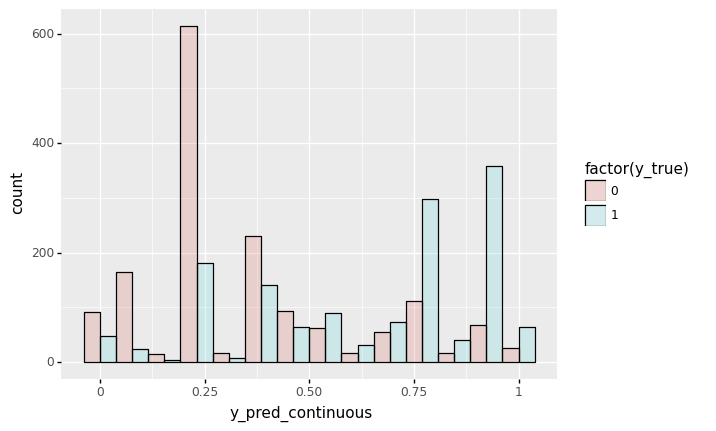

<ggplot: (8769899184150)>

In [11]:
## make into a dataframe
y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})
y_pred_df.sample(n = 10, random_state = 4484)

## plot prob versus true
(ggplot(y_pred_df, aes(x = 'y_pred_continuous', group = 'factor(y_true)',
                      fill = 'factor(y_true)')) +
geom_histogram(alpha = 0.2, position = "dodge", color = 'black'))


In [12]:
## precision as tp / tp+fp 
error_cond = [(y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 1),
             (y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 0),
              (y_pred_df['y_true'] == 0) & (y_pred_df['y_pred_binary'] == 0)]

error_codeto = ["TP", "FN", "TN"]

y_pred_df['error_cat'] = np.select(error_cond, error_codeto, default = "FP")
y_error = y_pred_df.error_cat.value_counts().reset_index()
y_error
y_error.columns = ['cat', 'n']

### precision
print("Precision is:-----------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FP", 'n'].iloc[0])

### recall
print("Recall is:---------------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FN", 'n'].iloc[0])

,index,error_cat
0,TN,1225
1,TP,954
2,FN,468
3,FP,353


Precision is:-----------


0.7299158377964805

Recall is:---------------


0.6708860759493671

## 2.4 Interpret the model

### 2.4.1 Feature importances

In [13]:
## get top words--- note that feature importance is UNSIGNED
## meaning they can predict either pos or neg label
feat_imp = pd.DataFrame({'feature_imp': dt.feature_importances_,
                         'feature_name': 
                        [col for col in X_train.columns if col not in non_feat]})
feat_imp.sort_values(by = 'feature_imp', ascending = False)


,feature_imp,feature_name
76,0.202610,great
39,0.100918,delici
102,0.086731,love
192,0.057604,told
4,0.034527,amaz
...,...,...
56,0.000000,experi
124,0.000000,offer
58,0.000000,feel
60,0.000000,find


### 2.4.2 variation across positive/negatively-labeled reviews

In [14]:
## look at mean counts of top words grouped by whether the 
## review has a positive label or not 
top_feat = feat_imp.sort_values(by = 'feature_imp', ascending = False)[0:10]
top_feat_list = top_feat.feature_name.to_list()
all_agg = [yelp_dtm.groupby(['metadata_label']).agg({one_feat: np.mean})
for one_feat in top_feat_list]
all_agg_df = pd.concat(all_agg, axis = 1)
all_agg_df


,great,delici,love,told,amaz,ask,favorit,friendli,noth,bad
metadata_label,,,,,,,,,,
0,0.171178,0.026424,0.085976,0.209461,0.022944,0.294921,0.027713,0.067672,0.140242,0.194896
1,0.557305,0.162248,0.284452,0.033416,0.104529,0.080641,0.116819,0.169014,0.043082,0.066142


### 2.4.3 Tree structure

Even though the actual tree is deeper, we're just visualizing the first few splits using the `max_depth` parameter 

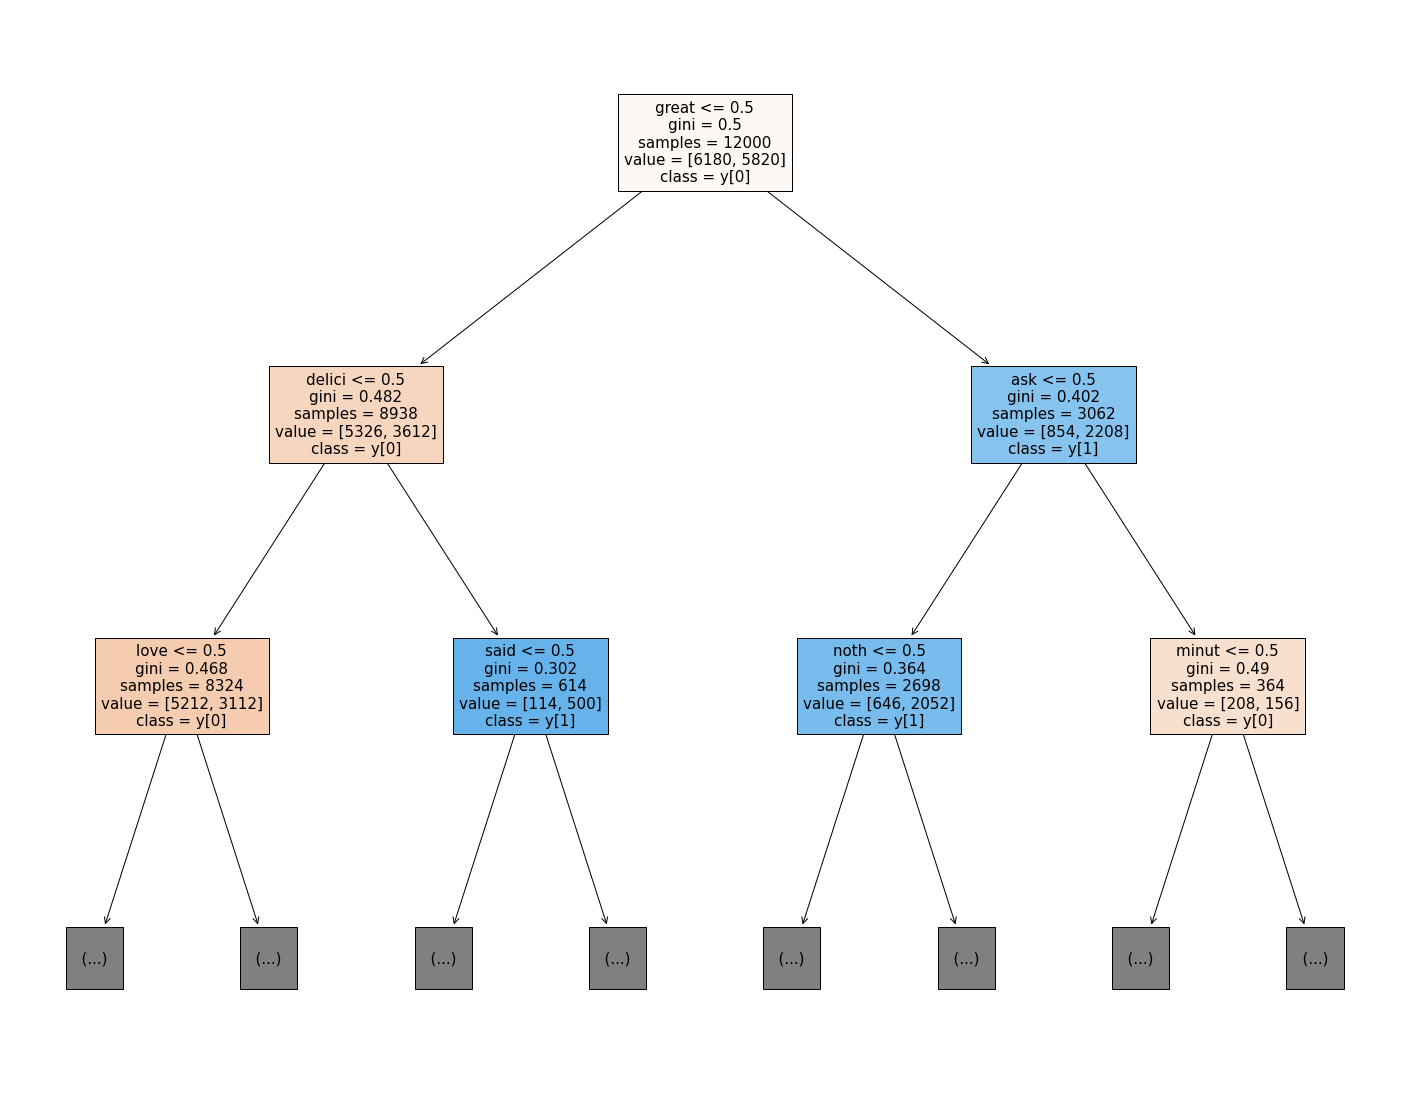

In [15]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, feature_names= X_features.columns,
                   class_names = True,
                   filled=True,
                  max_depth = 2) 

# 3. Estimate model: one model and hardcoding the hyperparameters (LASSO)

In [16]:
logit_lasso = LogisticRegression(penalty = "l1",max_iter=100, 
             C = 0.01, solver='liblinear')
logit_lasso.fit(X_features, y_train_man)

y_pred_las = logit_lasso.predict(X_test_man[[col for col in X_test_man.columns 
                if col not in non_feat]])
y_predprob_las = logit_lasso.predict_proba(X_test_man[[col for col in X_test_man.columns
                if col not in non_feat]])

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 23'. Pick better value with 'binwidth'.


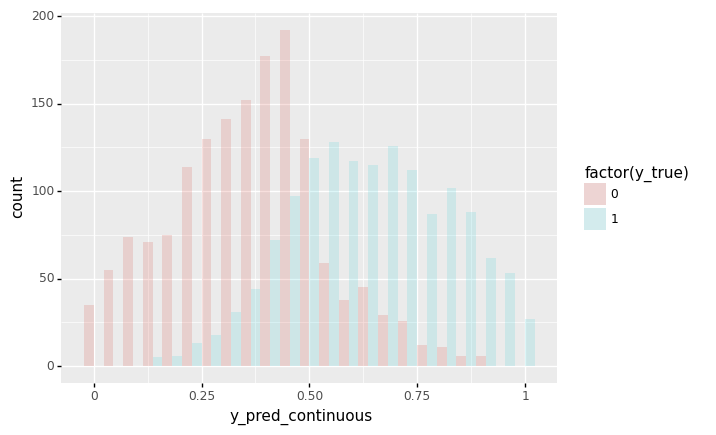

<ggplot: (8769902878025)>

In [17]:
## plot predictions- can see smoother than dt 
y_pred_df_las = pd.DataFrame({'y_pred_binary': y_pred_las,
                         'y_pred_continuous': [prob[1] for prob in y_predprob_las],
                         'y_true': y_test_man,
                        'model': 'lasso'})

(ggplot(y_pred_df_las, aes(x = 'y_pred_continuous', group = 'factor(y_true)',
                      fill = 'factor(y_true)')) +
geom_histogram(alpha = 0.2, position = "dodge"))


In [18]:
## get top features
las_coef = pd.DataFrame({'coef': logit_lasso.coef_[0],
                         'feature_name': 
                        [col for col in X_train.columns if col not in non_feat]})
las_coef.sort_values(by = 'coef', ascending = False)

## merge with top features from decision tree
## to get a sense of sign of highly-important dt features
top_both = pd.merge(las_coef, feat_imp, on = 'feature_name',
                   suffixes = ["_lasso", "_dt"])
top_both.sort_values(by = 'feature_imp', ascending = False).head(5)

,coef,feature_name
39,0.885623,delici
76,0.808427,great
102,0.627110,love
4,0.468283,amaz
17,0.403932,best
...,...,...
121,-0.241144,not
10,-0.263541,ask
192,-0.318996,told
122,-0.380616,noth


,coef,feature_name,feature_imp
76,0.808427,great,0.202610
39,0.885623,delici,0.100918
102,0.627110,love,0.086731
192,-0.318996,told,0.057604
4,0.468283,amaz,0.034527


# 4. Comparing performance across diff hyperparameters: LASSO

Rather than hardcoding a single parameter, we're iterating over a range of penalty terms

In [19]:
c_list = np.linspace(4, 0.0001, 10)

## define function that takes in one cost parameter
## and estimates model, returning pred
def one_las(one_c):
    one_lasso = LogisticRegression(penalty = "l1", max_iter=100, 
             C = one_c, solver='liblinear')
    one_lasso.fit(X_features, y_train_man)
    y_pred = one_lasso.predict(X_test_man[[col for col 
                in X_test_man.columns 
                if col not in non_feat]])
    y_pred_df = pd.DataFrame({'y_pred': y_pred, 
                             'y_true': y_test_man,
                             'cost': one_c})
    return(y_pred_df)

ESTIMATE_MODEL = False
if ESTIMATE_MODEL == True:
    all_pred = [one_las(one_c) for one_c in c_list]
    with open('../data/lasso_iterate.pkl', 'wb') as handle:
        pickle.dump(all_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('../data/lasso_iterate.pkl', 'rb') as handle:
        all_pred = pickle.load(handle)

In [20]:
## bind into one dataframe 
all_pred_df = pd.concat(all_pred)
all_pred_df.head()
## score one cost level 
def score_onedf(one_c, all_c):
    one_df = all_c[all_c.cost == one_c].copy()
    prec_onec =  precision_score(one_df['y_true'], one_df['y_pred'])
    return(prec_onec)
    
all_score = pd.DataFrame({'cost': c_list,
                         'precision': [score_onedf(one_c, all_pred_df) 
                                  for one_c in c_list]})
all_score

all_score[all_score.precision == np.max(all_score.precision)]

,y_pred,y_true,cost
0,0,0,4.0
1,0,0,4.0
2,1,1,4.0
3,0,0,4.0
4,0,0,4.0


/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,cost,precision
0,4.000000,0.806287
1,3.555567,0.806287
2,3.111133,0.806876
3,2.666700,0.806876
4,2.222267,0.806876
5,1.777833,0.807608
6,1.333400,0.807467
7,0.888967,0.807608
8,0.444533,0.808931
9,0.000100,0.000000


,cost,precision
8,0.444533,0.808931


# 4. Activity 

- Read the documentation here to initialize a ridge regression ($L_{2}$ penalty)- you can use the same cost parameter (C) and number of iterations as in the lasso example above: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Fit the model on the same training data and label as above
- Generate binary and continuous predictions
- Create a function that takes in a dataframe of binary predictions and true labels and manually calculates the $F_{1}$ score:

$$F_{1} = 2 * \dfrac{precision * recall}{precision + recall} = \dfrac{TP}{TP + 0.5(FP + FN)}$$

- Apply that function to calculate the F1 score for the decision tree and lasso (from above), and ridge regression (from the activity)

In [21]:
# your code here 
logit_ridge = LogisticRegression(penalty = "l2",max_iter=100, 
             C = 1, solver='liblinear')

X_feat_tr = X_train_man[[col for col in X_train_man.columns 
                if col not in non_feat]]
X_feat_te = X_test_man[[col for col in X_test_man.columns 
                if col not in non_feat]]
logit_ridge.fit(X_feat_tr, y_train_man)
## predict
y_hat = logit_ridge.predict(X_feat_te)
    


LogisticRegression(C=1, solver='liblinear')

In [22]:
def calc_myF1(fit_classifier, X_test, y_test, mod_name):
    
    ## predict
    y_hat = fit_classifier.predict(X_test)
    
    ## get the relevant counts
    df_pred = pd.DataFrame({'y_true': y_test,
                           'y_pred_binary': y_hat})
    
    ## counts of diff metrics
    tp = df_pred[(df_pred.y_true == 1) &
            (df_pred.y_pred_binary == 1)].shape[0]
    fp = df_pred[(df_pred.y_true == 0) &
            (df_pred.y_pred_binary == 1)].shape[0]
    fn = df_pred[(df_pred.y_true == 1) &
            (df_pred.y_pred_binary == 0)].shape[0]
    
    ## combine
    f1 = (tp)/(tp + 0.5*(fp + fn))
    
    ## return
    return("F1 score for " +  mod_name + " is: " + str(round(f1, 3)))


In [23]:
calc_myF1(logit_ridge, X_test = X_feat_te, y_test = y_test_man,
         mod_name = "ridge")
calc_myF1(logit_lasso, X_test = X_feat_te, y_test = y_test_man,
         mod_name = "lasso")
calc_myF1(dt, X_test = X_feat_te, y_test = y_test_man,
         mod_name = "decision tree")


'F1 score for ridge is: 0.792'

'F1 score for lasso is: 0.774'

'F1 score for decision tree is: 0.699'

In [24]:
ridge_c = pd.DataFrame({'coef': logit_ridge.coef_[0],
                        'feat': X_feat_tr.columns})

ridge_c[ridge_c.coef != 0].head()
ridge_c.sort_values(by = 'coef', ascending = False)

,coef,feat
0,0.009916,actual
1,-0.221784,almost
2,0.312366,also
3,0.497234,alway
4,1.617332,amaz


,coef,feat
39,1.784180,delici
4,1.617332,amaz
57,1.262520,favorit
76,1.102045,great
102,1.030121,love
...,...,...
121,-0.795988,not
113,-0.839702,money
92,-0.898647,left
42,-0.940770,disappoint
